<center><h1>Mini Project 9</h1></center>
<br>
<center><font size="5">Name - Spandan Patil</font></center>
<br>
<center><font size="4">Real Waste Data</font></center>

## 1. Transfer Learning for Image Classification

### Importing Libraries

In [1]:
import pandas as pd
import os
import cv2
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import optuna
from tensorflow.keras.applications import ResNet50, ResNet101, VGG16, EfficientNetB0
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model


/home/spandan/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-10 16:51:45.938780: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-10 16:51:46.037594: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-10 16:51:46.864594: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'

warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")

### b) Data Exploration and Pre-processing

#### i) & ii)

In [3]:
# Here we are reading each of the image and its label in the RealWaste dataset and converting it into a Dataframe.
dataset = pd.DataFrame(columns=["Image", "Label"])

# Path for the location of dataset
loc = "../data/RealWaste/"

# The list of Waste Labels.
lbls = ["Cardboard", "Food Organics", "Glass", "Metal", "Miscellaneous Trash", "Paper", "Plastic", "Textile Trash", "Vegetation"]     
        
# Here we are iterating through each of the waste label and reading the images for that label.        
for idx, lbl in enumerate(lbls):
    folder_path = loc + f"{idx+1}-" + lbl + "/"
    num_files = len([f for f in os.listdir(folder_path) if f.lower().endswith(".jpg")])
    for i in range(1, num_files+1):
        img_path = folder_path + f"{lbl}_{i}.jpg"
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        dataset.loc[len(dataset)] = [img_rgb, lbl]



In [4]:
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(dataset["Label"].values), 
    y=dataset["Label"].values
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

In [5]:
# Here we are performing One-Hot Encoding for your labels and converting them into binary vectors.
encoder = OneHotEncoder(sparse_output=False)
    
encoded_lbls = encoder.fit_transform(dataset[["Label"]])

# Here we create a new DataFrame with the one-hot encoded labels and adding it to the original dataset.
dataset = dataset.join(pd.DataFrame(encoded_lbls, columns=encoder.categories_[0]))

# Here we drop the original label column
dataset.drop(columns=["Label"], inplace=True)

In [6]:
# This is a function to resize all the images in a standard size.
def img_resize(img):
    resized_img = cv2.resize(img, (160, 160))
    return resized_img

In [7]:
# Here we are applying resizing function to all the images in the dataset.
dataset['Image'] = dataset['Image'].apply(img_resize)

In [8]:
# Here we are splitting our dataset into Train and Test sets.
X_train, X_test, y_train, y_test = train_test_split(dataset['Image'], dataset[lbls], test_size=0.2, stratify=dataset[lbls], random_state=42)

X_train = np.stack(X_train.to_numpy())
X_test  = np.stack(X_test.to_numpy())

y_train = np.array(y_train)
y_test  = np.array(y_test)

In [9]:
# Here we are creating our validation dataset, by randomly selecting 20% of the sample from each label.
_, X_val, _, y_val = train_test_split(dataset['Image'], dataset[lbls], test_size=0.2, stratify=dataset[lbls], random_state=42)

X_val   = np.stack(X_val.to_numpy())
y_val   = np.array(y_val)

### c) Transfer Learning

#### i), ii), iii)

In [10]:
def augment_image(image):
    """Apply augmentations: random crop, zoom, rotation, flip, contrast, and translation."""

    height, width = image.shape[:2]

    # Mild rotation: -5 to +5 degrees
    rotation_angle = random.uniform(-10, 10)
    matrix = cv2.getRotationMatrix2D((width / 2, height / 2), rotation_angle, 1)
    image = cv2.warpAffine(image, matrix, (width, height), borderMode=cv2.BORDER_REFLECT)

    # Random crop: retain 95–100% of original area
    crop_scale = random.uniform(0.90, 1.0)
    crop_h, crop_w = int(height * crop_scale), int(width * crop_scale)
    start_x = random.randint(0, height - crop_h)
    start_y = random.randint(0, width - crop_w)
    cropped = image[start_x:start_x+crop_h, start_y:start_y+crop_w]
    image = cv2.resize(cropped, (width, height))

    # Random zoom (scale: 1.0-1.2x)
    zoom_factor = random.uniform(1.0, 1.3)
    image = cv2.resize(image, (int(width * zoom_factor), int(height * zoom_factor)))
    image = image[:height, :width]  # crop back to original size

    # Random horizontal or vertical flip (50% chance for each)
    flip_type = random.choice([0, 1])  # 0 = vertical, 1 = horizontal
    if random.random() < 0.5:  # 50% chance to apply flip
        image = cv2.flip(image, flip_type)

    # Random contrast adjustment (factor between 0.9 and 1.1)
    contrast_factor = random.uniform(0.9, 1.1)
    image = np.uint8(np.clip(image * contrast_factor, 0, 255))

    # Random translation (shifting image along x and y axis)
    translation_x = random.randint(-10, 10)  # Shift x by -10 to +10 pixels
    translation_y = random.randint(-10, 10)  # Shift y by -10 to +10 pixels
    translation_matrix = np.float32([[1, 0, translation_x], [0, 1, translation_y]])
    image = cv2.warpAffine(image, translation_matrix, (width, height), borderMode=cv2.BORDER_REFLECT)

    return image

In [11]:
X_train = np.stack([augment_image(image) for image in X_train])

In [12]:
def normalize(x, y):
    # Define mean and standard deviation for ImageNet normalization
    mean = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
    std = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)
    
    # Reshape mean and std to match the shape of the image [height, width, channels]
    mean = tf.reshape(mean, [1, 1, 3])
    std = tf.reshape(std, [1, 1, 3])

    # Normalize the image: Convert to float and scale to [0, 1]
    x = tf.cast(x, tf.float32) / 255.0  # Scale to [0, 1] if the image is uint8
    # Apply normalization: (x - mean) / std
    x = (x - mean) / std
    
    return x, y

In [13]:
batch_size = 5
epoches = 100
num_classes = 9

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(normalize, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(normalize, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(normalize, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

2025-05-10 16:52:09.427229: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-10 16:52:09.618368: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-10 16:52:09.618417: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-10 16:52:09.621113: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-10 16:52:09.621156: I external/local_xla/xla/stream_executor

In [14]:
def evaluate(model, history):

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Val accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("accuracy")
    plt.title("Training and Validation accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(normalize, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    # Get predictions (probabilities)
    y_train_pred = model.predict(train_dataset, verbose=0)
    y_val_pred   = model.predict(val_dataset, verbose=0)
    y_test_pred  = model.predict(test_dataset, verbose=0)

    # Convert one-hot to class labels
    y_train_true = np.argmax(y_train, axis=1)
    y_val_true   = np.argmax(y_val, axis=1)
    y_test_true  = np.argmax(y_test, axis=1)

    y_train_pred_classes = np.argmax(y_train_pred, axis=1)
    y_val_pred_classes   = np.argmax(y_val_pred, axis=1)
    y_test_pred_classes  = np.argmax(y_test_pred, axis=1)

    # AUC (weighted average)
    train_auc = roc_auc_score(y_train, y_train_pred, average='weighted', multi_class='ovr')
    val_auc   = roc_auc_score(y_val, y_val_pred, average='weighted', multi_class='ovr')
    test_auc  = roc_auc_score(y_test, y_test_pred, average='weighted', multi_class='ovr')

    # Report
    for name, y_true, y_pred, auc in [
        ("Train", y_train_true, y_train_pred_classes, train_auc),
        ("Val",   y_val_true,   y_val_pred_classes,   val_auc),
        ("Test",  y_test_true,  y_test_pred_classes,  test_auc)
    ]:
        print(f"\n{name} Evaluation:")
        print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
        print(f"Recall:    {recall_score(y_true, y_pred, average='weighted'):.4f}")
        print(f"F1 Score:  {f1_score(y_true, y_pred, average='weighted'):.4f}")
        print(f"AUC:       {auc:.4f}")

#### iv) & v)

##### ResNet50:

In [15]:
# Here we are replacing the final fully connected layer and the output layer with our custom layers.
# Here we are loading pretrained ResNet101
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
base_model.trainable = False

resNet50_model = models.Sequential(name="ResNet50_Custom")
resNet50_model.add(base_model)
resNet50_model.add(layers.GlobalAveragePooling2D())

# Here is the custom dense layer with L2 regularization
resNet50_model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.01)))
resNet50_model.add(layers.BatchNormalization())
resNet50_model.add(layers.ReLU())
resNet50_model.add(layers.Dropout(0.2))

# Here is the Output layer with Softmax activation
resNet50_model.add(layers.Dense(num_classes, activation='softmax'))

# Here we are compiling the model with the Adam optimizer and multinomial cross-entropy loss
resNet50_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# This is to display Model summary to inspect the architecture
resNet50_model.summary()

Model: "ResNet50_Custom"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,115,593 (91.99 MB)

 Trainable params: 527,369 (2.01 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

In [16]:
model_path = "/mnt/d/my_models/ResNet50_model.keras"

callbacks = [
    EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
    ModelCheckpoint(model_path, monitor='val_accuracy', mode='max', save_best_only=True, save_freq='epoch'),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
]

# Fit the model
history = resNet50_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epoches,
    callbacks=callbacks,
    verbose=1,
    class_weight=class_weight_dict
)

Epoch 1/100


I0000 00:00:1746921136.195094  136528 service.cc:145] XLA service 0x7f569005cf30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746921136.195279  136528 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-05-10 16:52:16.350582: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-10 16:52:17.348058: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 19/761 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.1429 - loss: 6.9189 

I0000 00:00:1746921141.659979  136528 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


761/761 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2195 - loss: 5.5144

I0000 00:00:1746921151.035627  136523 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_subtract_fusion_1', 8 bytes spill stores, 64 bytes spill loads

I0000 00:00:1746921152.818561  136905 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1760', 16 bytes spill stores, 16 bytes spill loads



761/761 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - accuracy: 0.2195 - loss: 5.5134 - val_accuracy: 0.4069 - val_loss: 3.6506 - learning_rate: 1.0000e-04
Epoch 2/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3670 - loss: 3.4761 - val_accuracy: 0.4364 - val_loss: 2.9534 - learning_rate: 1.0000e-04
Epoch 3/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4249 - loss: 2.8778 - val_accuracy: 0.4332 - val_loss: 2.7333 - learning_rate: 1.0000e-04
Epoch 4/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4404 - loss: 2.5353 - val_accuracy: 0.4132 - val_loss: 2.5722 - learning_rate: 1.0000e-04
Epoch 5/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.4633 - loss: 2.3040 - val_accuracy: 0.4416 - val_loss: 2.3975 - learning_rate: 1.0000e-04
Epoch 6/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5112 - loss: 2.1243 - val_accuracy: 0.4448 - val_loss: 2.2420 - learning_rate: 1.0000e-04
Epoch 7/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accu

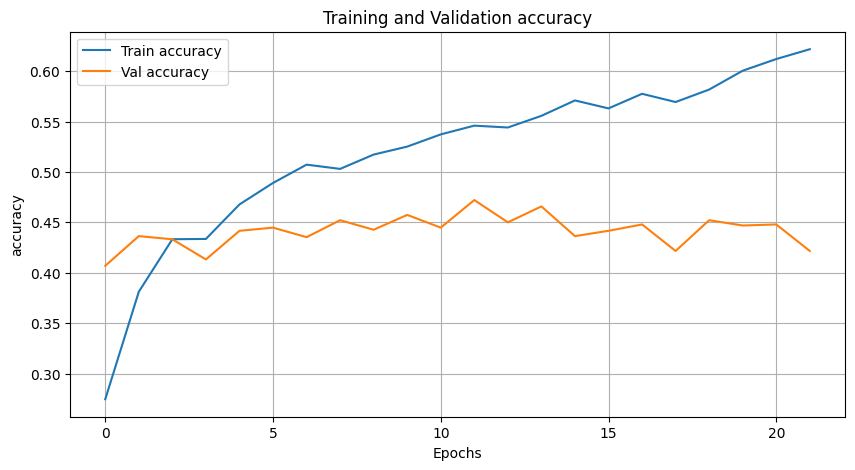


Train Evaluation:
Precision: 0.6936
Recall:    0.6882
F1 Score:  0.6862
AUC:       0.9463

Val Evaluation:
Precision: 0.5146
Recall:    0.4721
F1 Score:  0.4403
AUC:       0.8592

Test Evaluation:
Precision: 0.5146
Recall:    0.4721
F1 Score:  0.4403
AUC:       0.8592


In [17]:
evaluate(resNet50_model, history)

##### ResNet100:

In [18]:
# Here we are replacing the final fully connected layer and the output layer with our custom layers.
# Here we are loading pretrained ResNet101
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
base_model.trainable = False

resNet100_model = models.Sequential(name="ResNet100_Custom")
resNet100_model.add(base_model)
resNet100_model.add(layers.GlobalAveragePooling2D())

# Here is the custom dense layer with L2 regularization
resNet100_model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.01)))
resNet100_model.add(layers.BatchNormalization())
resNet100_model.add(layers.ReLU())
resNet100_model.add(layers.Dropout(0.2))

# Here is the Output layer with Softmax activation
resNet100_model.add(layers.Dense(num_classes, activation='softmax'))

# Here we are compiling the model with the Adam optimizer and multinomial cross-entropy loss
resNet100_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# This is to display Model summary to inspect the architecture
resNet100_model.summary()

Model: "ResNet100_Custom"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)          │ (None, 5, 5, 2048)     │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,186,057 (164.74 MB)

 Trainable params: 527,369 (2.01 MB)

 Non-trainable params: 42,658,688 (162.73 MB)

In [19]:
model_path = "/mnt/d/my_models/ResNet100_model.keras"

callbacks = [
    EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
    ModelCheckpoint(model_path, monitor='val_accuracy', mode='max', save_best_only=True, save_freq='epoch'),
    ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
]

# Fit the model
history = resNet100_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epoches,
    callbacks=callbacks,
    verbose=1,
    class_weight=class_weight_dict
)

Epoch 1/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1908 - loss: 5.2470

I0000 00:00:1746921401.116787  136525 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_subtract_fusion_1', 8 bytes spill stores, 64 bytes spill loads



761/761 ━━━━━━━━━━━━━━━━━━━━ 37s 34ms/step - accuracy: 0.1909 - loss: 5.2457 - val_accuracy: 0.3743 - val_loss: 3.0763 - learning_rate: 1.0000e-04
Epoch 2/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.3404 - loss: 3.0381 - val_accuracy: 0.3775 - val_loss: 2.6742 - learning_rate: 1.0000e-04
Epoch 3/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.3652 - loss: 2.6021 - val_accuracy: 0.3954 - val_loss: 2.3943 - learning_rate: 1.0000e-04
Epoch 4/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.4107 - loss: 2.3201 - val_accuracy: 0.3912 - val_loss: 2.3198 - learning_rate: 1.0000e-04
Epoch 5/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.4003 - loss: 2.1946 - val_accuracy: 0.4175 - val_loss: 2.1453 - learning_rate: 1.0000e-04
Epoch 6/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.4140 - loss: 2.1105 - val_accuracy: 0.4027 - val_loss: 2.1263 - learning_rate: 1.0000e-04
Epoch 7/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - a

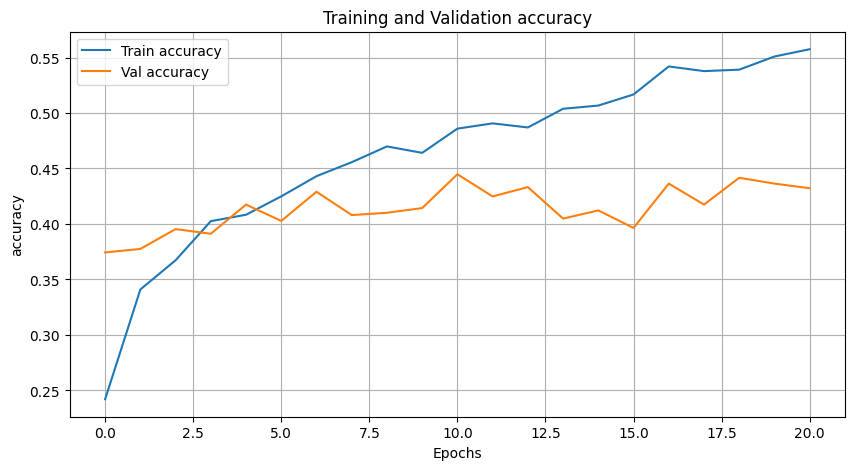


Train Evaluation:
Precision: 0.6392
Recall:    0.5901
F1 Score:  0.5856
AUC:       0.9192

Val Evaluation:
Precision: 0.4735
Recall:    0.4448
F1 Score:  0.4133
AUC:       0.8476

Test Evaluation:
Precision: 0.4735
Recall:    0.4448
F1 Score:  0.4133
AUC:       0.8476


In [20]:
evaluate(resNet100_model, history)

##### VGG16:

In [21]:
# Here we are replacing the final fully connected layer and the output layer with our custom layers.
# Here we are loading pretrained VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
base_model.trainable = False

vGG16_model = models.Sequential(name="VGG16_Custom")
vGG16_model.add(base_model)

vGG16_model.add(layers.GlobalAveragePooling2D())

# Here is the custom dense layer with L2 regularization
vGG16_model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.01)))
vGG16_model.add(layers.BatchNormalization())
vGG16_model.add(layers.ReLU())
vGG16_model.add(layers.Dropout(0.2))
 

# Here is the Output layer with Softmax activation
vGG16_model.add(layers.Dense(num_classes, activation='softmax'))

# Here we are compiling the model with the Adam optimizer and multinomial cross-entropy loss
vGG16_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# This is to display Model summary to inspect the architecture
vGG16_model.summary()

Model: "VGG16_Custom"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,849,353 (56.65 MB)

 Trainable params: 134,153 (524.04 KB)

 Non-trainable params: 14,715,200 (56.13 MB)

In [22]:
model_path = "/mnt/d/my_models/vGG16_model.keras"

callbacks = [
    EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
    ModelCheckpoint(model_path, monitor='val_accuracy', mode='max', save_best_only=True, save_freq='epoch'),
    ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
]

# Fit the model
history = vGG16_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epoches,
    callbacks=callbacks,
    verbose=1,
    class_weight=class_weight_dict
)

Epoch 1/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.2736 - loss: 5.2486 - val_accuracy: 0.5657 - val_loss: 4.0070 - learning_rate: 1.0000e-04
Epoch 2/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5061 - loss: 3.9982 - val_accuracy: 0.6299 - val_loss: 3.3708 - learning_rate: 1.0000e-04
Epoch 3/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5834 - loss: 3.3687 - val_accuracy: 0.6730 - val_loss: 2.8949 - learning_rate: 1.0000e-04
Epoch 4/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5971 - loss: 2.9126 - val_accuracy: 0.7014 - val_loss: 2.5350 - learning_rate: 1.0000e-04
Epoch 5/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6527 - loss: 2.5668 - val_accuracy: 0.7066 - val_loss: 2.3033 - learning_rate: 1.0000e-04
Epoch 6/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6575 - loss: 2.2812 - val_accuracy: 0.7024 - val_loss: 2.1045 - learning_rate: 1.0000e-04
Epoch 7/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 11s 1

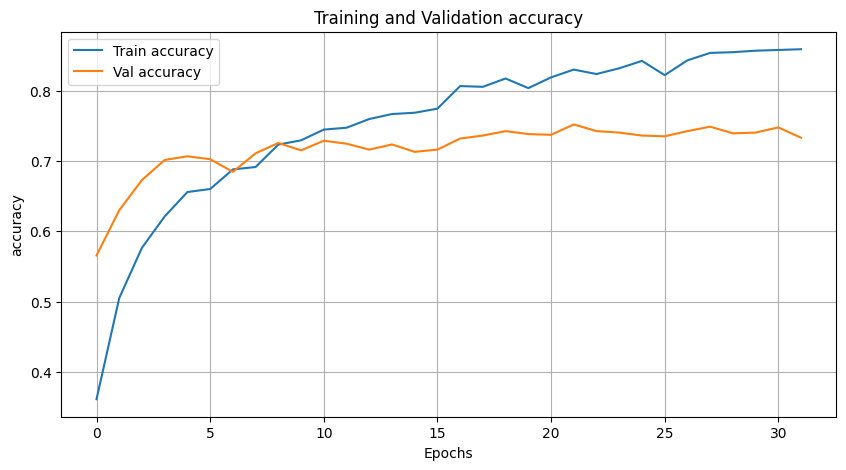


Train Evaluation:
Precision: 0.9400
Recall:    0.9392
F1 Score:  0.9387
AUC:       0.9975

Val Evaluation:
Precision: 0.7568
Recall:    0.7518
F1 Score:  0.7499
AUC:       0.9610

Test Evaluation:
Precision: 0.7568
Recall:    0.7518
F1 Score:  0.7499
AUC:       0.9610


In [23]:
evaluate(vGG16_model, history)

##### EfficientNetB0:

In [24]:
# Here we are replacing the final fully connected layer and the output layer with our custom layers.
# Here we are loading pretrained EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
base_model.trainable = False

effnetB0_model = models.Sequential(name="EfficientNetB0_Custom")
effnetB0_model.add(base_model)

effnetB0_model.add(layers.GlobalAveragePooling2D())  

# Here is the custom dense layer with L2 regularization
effnetB0_model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.01))) 
effnetB0_model.add(layers.BatchNormalization())
effnetB0_model.add(layers.ReLU())  
effnetB0_model.add(layers.Dropout(0.2))  

# Here is the Output layer with Softmax activation
effnetB0_model.add(layers.Dense(num_classes, activation='softmax'))

# Here we are compiling the model with the Adam optimizer and multinomial cross-entropy loss
effnetB0_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# This is to display Model summary to inspect the architecture
effnetB0_model.summary()

Model: "EfficientNetB0_Custom"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,380,844 (16.71 MB)

 Trainable params: 330,761 (1.26 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

In [25]:
model_path = "/mnt/d/my_models/effnetB0_model.keras"

callbacks = [
    EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
    ModelCheckpoint(model_path, monitor='val_accuracy', mode='max', save_best_only=True, save_freq='epoch'),
    ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
]

# Fit the model
history = effnetB0_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epoches,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


I0000 00:00:1746922164.317327  151145 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_10314', 20 bytes spill stores, 20 bytes spill loads



761/761 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.1996 - loss: 6.0954

I0000 00:00:1746922197.225279  136525 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_subtract_fusion_1', 8 bytes spill stores, 64 bytes spill loads



761/761 ━━━━━━━━━━━━━━━━━━━━ 55s 42ms/step - accuracy: 0.1997 - loss: 6.0948 - val_accuracy: 0.2576 - val_loss: 5.7724 - learning_rate: 1.0000e-04
Epoch 2/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.2730 - loss: 4.6996 - val_accuracy: 0.2681 - val_loss: 4.8006 - learning_rate: 1.0000e-04
Epoch 3/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.2917 - loss: 3.9121 - val_accuracy: 0.2808 - val_loss: 4.1274 - learning_rate: 1.0000e-04
Epoch 4/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3077 - loss: 3.4288 - val_accuracy: 0.2808 - val_loss: 3.8611 - learning_rate: 1.0000e-04
Epoch 5/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3111 - loss: 3.0788 - val_accuracy: 0.2503 - val_loss: 3.7321 - learning_rate: 1.0000e-04
Epoch 6/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3180 - loss: 2.8185 - val_accuracy: 0.2019 - val_loss: 3.6851 - learning_rate: 1.0000e-04
Epoch 7/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0

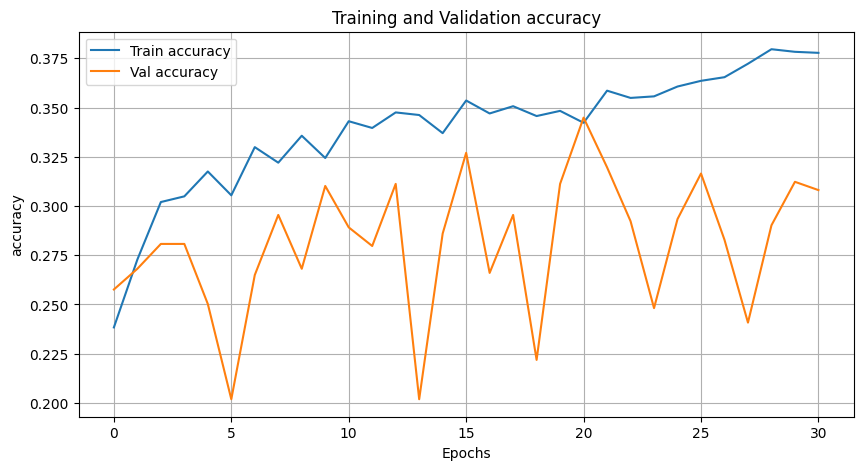


Train Evaluation:
Precision: 0.4579
Recall:    0.3452
F1 Score:  0.2748
AUC:       0.8133

Val Evaluation:
Precision: 0.2911
Recall:    0.3449
F1 Score:  0.2779
AUC:       0.7530

Test Evaluation:
Precision: 0.2911
Recall:    0.3449
F1 Score:  0.2779
AUC:       0.7530


/home/spandan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/spandan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/spandan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
evaluate(effnetB0_model, history)

As we can see from above the best model is VGG16 which has the highest accuracy.